# Baseline computation

For each cell (folder) in our dataset directory, this notebook computes normalization constants with which we normalize fluorescent signals and forces.

### Zyxin variations
Cells express different amounts of total zyxin. To control for this variation, we normalize zyxin intensities (and analogous for other proteins) according to 

$$\hat{Z}^{\text{cell}}(t) =  \frac{ Z^{\text{cell}}(t)  - \mu^{\text{cell}}_{\text{out}} }{\mu^{\text{cell}}_{\text{in}} - \mu^{\text{cell}}_{\text{out}}} $$

$\mu^{\text{cell}}_{\text{out}}$ represents the mean zyxin signal measured _outside_ of the cell mask, while $\mu^{\text{cell}}_{\text{in}}$ measures the average zyxin intensity within the cell.
Averages are taken over time and space. 

### Force variations
Due to slight variations in substrate preparation, the forces measured on average (averaged across all cells) will differ from dataset to dataset.

To control for this, we normalize forces in each dataset by the average force exerted across all cells in that dataset. In this way, each dataset will have the same distribution of forces as expected (since they are prepared under identical conditions).

$$\hat{F}^{\text{cell}}(t) =  \frac{ F^{\text{cell}}(t) }{\mu_F^{\text{dataset}}} $$

$\mu_F^{\text{dataset}}$ represents the average force measured across all cells in the dataset to which "cell" belongs. Averages are taken over time and space. Over all our datasets, the average force is 267 Pa. Therefore, a measured force of 1 kPa will, in new units, have value ~4. We multiply these new units by 1/4 so that 1 kPa will be represented by 1 in the new units. Everywhere in the following, we report these new units as kPa. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.ndimage

import matplotlib as mpl
import torch
import torchvision 
import time
import sys

root = './'

if root not in sys.path: sys.path.append(root) # in root I have my utils module, from which I want to import things
from utils.nb_utils import *

%matplotlib inline

# Load data

In [3]:
data_root = os.path.join(root, 'data', 'ZyxAct_16kPa_small')
subdirs = [x for x in os.listdir(data_root) if os.path.isdir(os.path.join(data_root, x)) and ('cell' in x)]

print((np.asarray(subdirs)))
print(len(subdirs))

['cell_0' 'cell_2' 'cell_3' 'cell_1']
4


# Plot cells

cell_0
cell_2
cell_3
cell_1


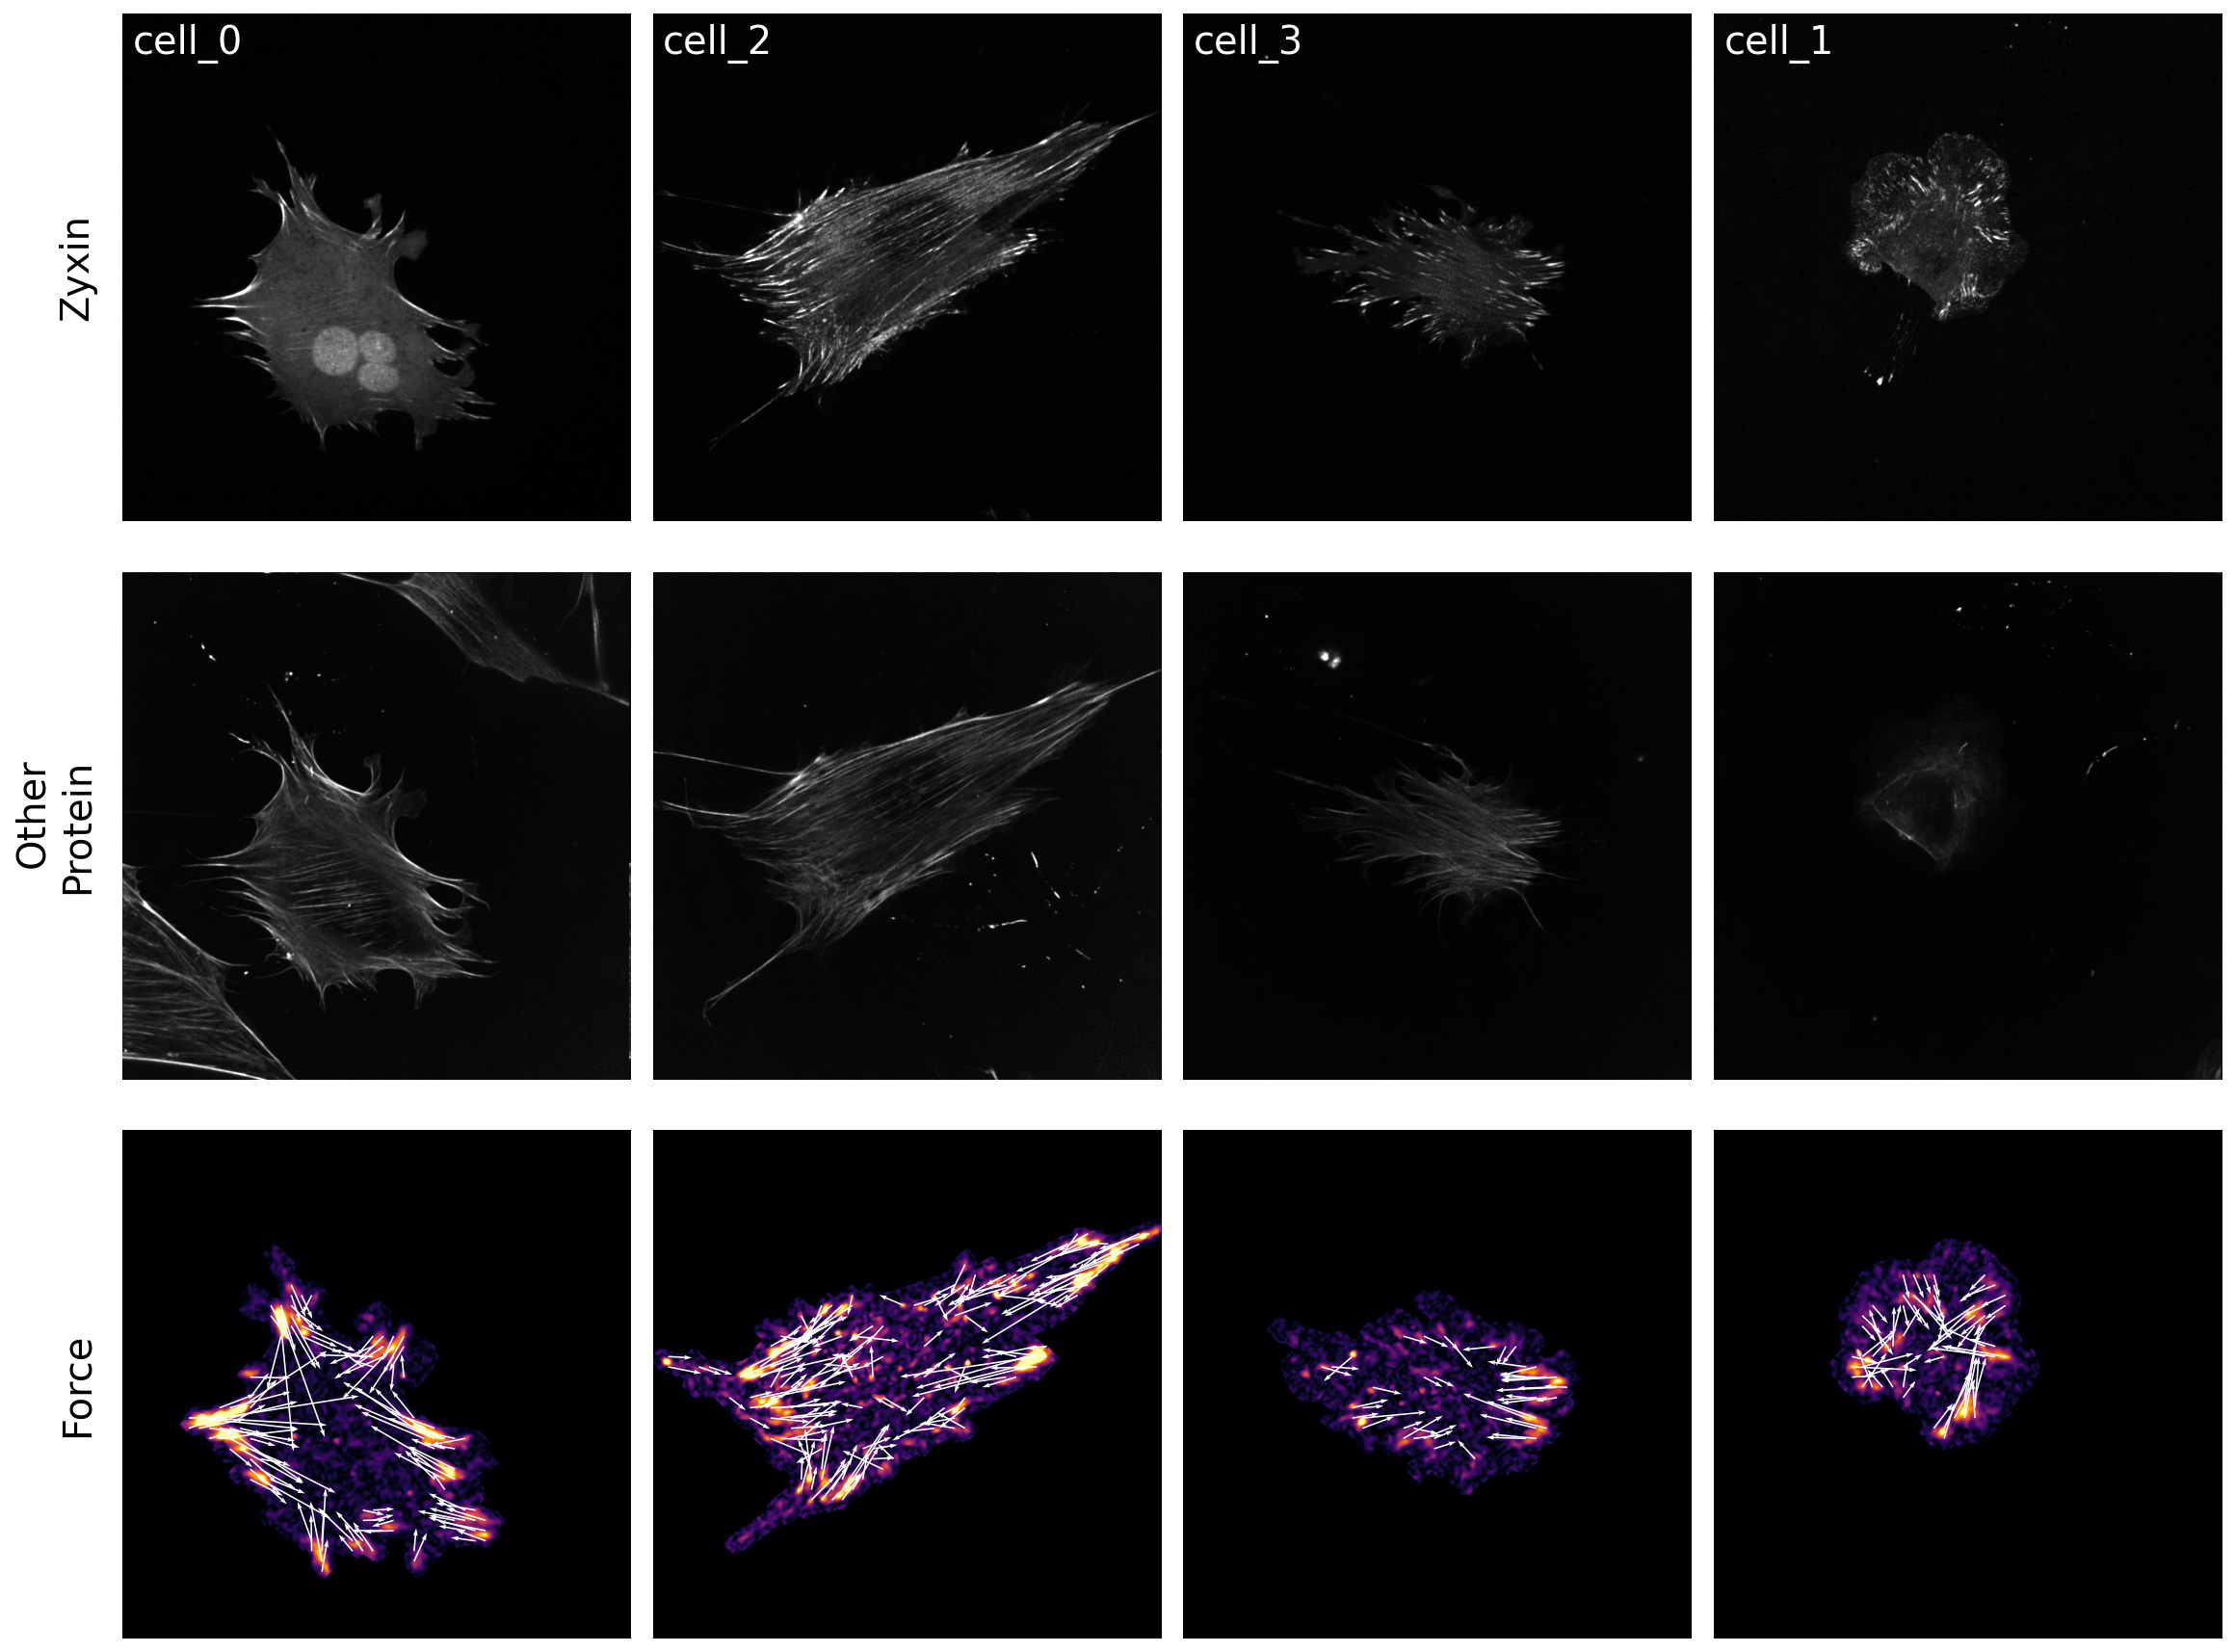

In [8]:
fig,ax = plt.subplots(3,len(subdirs),figsize=(len(subdirs)*4, 3*4), dpi=144, constrained_layout=1)

frame = 0
channels = [6,7]

for n,a in enumerate(ax.T):
    # Each item in the folders has channel structure [Displacement X, Displacement Y, Force X, Force Y, Mask, ForceMask, Zyxin, <other protein>]. 
    print(subdirs[n])
    im = np.load(os.path.join(data_root, subdirs[n], 'Disp_Trac_CellMask_ForceMask_Actin_%d.npy'%frame)) # has shape [7, H, W] where H, W are height and width of image
    im_ch0 = im[6]*1. # This is zyxin
    im_ch1 = im[7]*1. # This is other protein, where other = [actin, myosin, paxillin, mitochondria]
    mask = im[4]!=0
    mask = scipy.ndimage.binary_dilation(mask, iterations=20)#, structure=disk(r), iterations=1)
    im[:, mask==0] = 0

    f = im[[2,3]]
    mag = np.linalg.norm(f, axis=0)
    
    a[0].imshow(im_ch0/np.max(im_ch0), origin='lower', cmap='gray', vmax=0.5)
    a[1].imshow(im_ch1/np.max(im_ch1), origin='lower', cmap='gray', vmax=0.5)
    
    a[2].imshow(mag, origin='lower', cmap='inferno', vmax=2000)
    a[2].quiver(*make_vector_field(*f, downsample=20, threshold=400), color='w', scale=1e4, width=0.003)
    
    a[0].text(0.02, 0.98, subdirs[n], color='w', fontsize=20, transform=a[0].transAxes, ha='left', va='top')
    
ax[0][0].text(-0.05, 0.5, 'Zyxin', transform=ax[0][0].transAxes, ha='right', va='center', rotation=90, fontsize=20)
ax[1][0].text(-0.05, 0.5, 'Other\nProtein', transform=ax[1][0].transAxes, ha='right', va='center', rotation=90, fontsize=20)
ax[2][0].text(-0.05, 0.5, 'Force', transform=ax[2][0].transAxes, ha='right', va='center', rotation=90, fontsize=20)

for a in ax.flat:
    a.axis('off')

In [9]:
celldirs = subdirs

mean_zyx = {}
mean_act = {}
mean_F = {}

for R, Cdirs in zip([data_root], [celldirs]):
    t0 = time.time()
    
    for i, cell in enumerate(Cdirs):
        celldir = os.path.join(R, cell)
        
        Zavg_out = 0
        Zavg_in = 0        
        Zstd_out = 0
        Zstd_in = 0
        
        Aavg_out = 0
        Aavg_in = 0        
        Astd_out = 0
        Astd_in = 0
        
        Fmax = []
        Favg = []        
        Fstd = [] 
        F99pct = []
        
        z_in, z_out = [], []
        a_in, a_out = [], []
                
        for t, file in enumerate(os.listdir(celldir)): # Unsorted list
            frame = np.load(os.path.join(celldir, file))
            act = frame[7]
            zyxin = frame[6]
            mask = frame[4]
            F = np.linalg.norm(frame[[2,3]], axis=0)

            Zavg_out += zyxin[mask==0].mean() / len(os.listdir(celldir)) # Average intensity outside of cell
            Zavg_in += zyxin[mask!=0].mean()  / len(os.listdir(celldir)) # Average intensity inside of cell
            Zstd_out += zyxin[mask==0].std() / len(os.listdir(celldir))
            Zstd_in += zyxin[mask!=0].std()  / len(os.listdir(celldir))
            
            Aavg_out += act[mask==0].mean() / len(os.listdir(celldir))
            Aavg_in += act[mask!=0].mean()  / len(os.listdir(celldir))
            Astd_out += act[mask==0].std() / len(os.listdir(celldir))
            Astd_in += act[mask!=0].std()  / len(os.listdir(celldir))
            
            Fmax.append(F.max())
            Favg.append(F.mean())      
            Fstd.append(F.std())
            F99pct.append(np.quantile(F.ravel(), 0.99))
            
            z_out.append(zyxin[mask==0].mean())
            z_in.append(zyxin[mask!=0].mean())
            
            a_out.append(act[mask==0].mean())
            a_in.append(act[mask!=0].mean())

        mean_zyx[cell] = [Zavg_out, Zavg_in, Zstd_out, Zstd_in, z_out, z_in]
        mean_act[cell] = [Aavg_out, Aavg_in, Astd_out, Astd_in, a_out, a_in]
        mean_F[cell] = [Fmax, Favg, Fstd, F99pct]
        
        print('Time for %u cell:\t %.2f'%(i+1, time.time()-t0))

Time for 1 cell:	 19.28
Time for 2 cell:	 39.32
Time for 3 cell:	 59.24
Time for 4 cell:	 78.10


In [17]:
df = pd.DataFrame(columns=['cell', 'zyxin_lifetime_mean_outside', 'zyxin_lifetime_mean_inside', 'actin_lifetime_mean_outside', 'actin_lifetime_mean_inside'])

for n,cell in enumerate(celldirs):
    zx_out = mean_zyx[cell][0]
    zx_in = mean_zyx[cell][1]
    ac_out = mean_act[cell][0]
    ac_in = mean_act[cell][1]
    
    dict_append = {'cell': cell, 
                   'zyxin_lifetime_mean_outside': zx_out, # Average intensity outside of cell, averaged over entire time series
                   'zyxin_lifetime_mean_inside': zx_in,   # Average intensity inside of cell, averaged over entire time series
                   'actin_lifetime_mean_outside': ac_out, 
                   'actin_lifetime_mean_inside': ac_in}
    df = df.append(dict_append, ignore_index=1)

    
if input("Save?")=='save':
    df.to_csv(os.path.join(data_root, 'cell_mean_baselines.csv'))

df.head(20)

Save? save


,cell,zyxin_lifetime_mean_outside,zyxin_lifetime_mean_inside,actin_lifetime_mean_outside,actin_lifetime_mean_inside
0,cell_0,5.212261,129.156811,76.050815,509.421164
1,cell_2,5.025706,97.583928,39.297172,254.211467
2,cell_3,4.561842,49.513123,29.585590,434.396728
3,cell_1,4.430032,28.235241,29.364622,306.488766


# Plot adjusted trajectories

In [12]:
celldirs = subdirs

mean_zyx_adj = {}

for R, Cdirs in zip([data_root], [celldirs]):
    t0 = time.time()
    
    for i, cell in enumerate(Cdirs):
        celldir = os.path.join(R, cell)
                
        zx_out = mean_zyx[cell][0]
        zx_in = mean_zyx[cell][1]
        
        z_in_adj, z_out_adj = [], []
        
        for file in os.listdir(celldir):
            t = int(file.split('_')[-1].split('.')[0]) # split frame index from filename

            frame = np.load(os.path.join(celldir, file))
            act = frame[7]
            zyxin = frame[6]
            mask = frame[4]
            
            zyxin -= zx_out
            zyxin[zyxin<0] = 0
            zyxin /= (zx_in - zx_out)
            
            z_out_adj.append([t, zyxin[mask==0].mean()])
            z_in_adj.append([t, zyxin[mask!=0].mean()])
            

        mean_zyx_adj[cell] = np.asarray([z_out_adj, z_in_adj])
        
        print('Time for %u cell:\t %.2f'%(i+1, time.time()-t0))

Time for 1 cell:	 6.57
Time for 2 cell:	 13.00
Time for 3 cell:	 17.68
Time for 4 cell:	 22.09


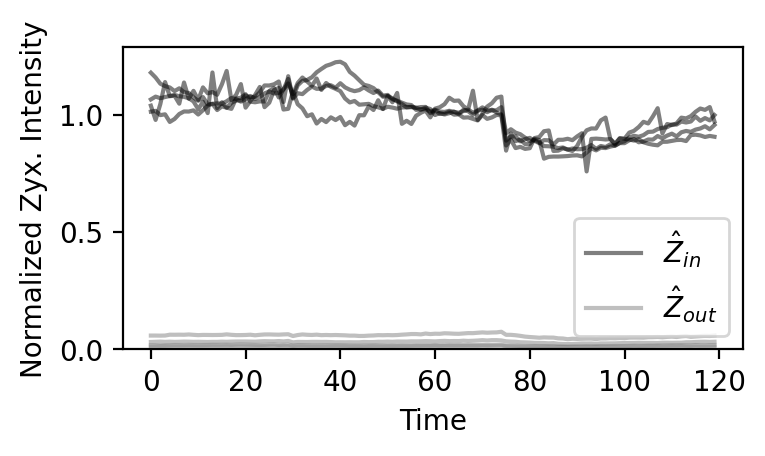

In [13]:
zyx_out_in_bycell = [[k, i] for k,i in mean_zyx_adj.items()]
cell_names = [d[0] for d in zyx_out_in_bycell]

time_bycell = np.asarray([d[1][0][:,0] for d in zyx_out_in_bycell])
zyx_data_out = np.asarray([d[1][0][:,1] for d in zyx_out_in_bycell])
zyx_data_in = np.asarray([d[1][1][:,1] for d in zyx_out_in_bycell])

fig,ax=plt.subplots(1,1,figsize=(4,2), dpi=200)

for i in range(len(cell_names)):
    T = time_bycell[i]
    Tsort = np.argsort(T)
    ax.plot(T[Tsort], zyx_data_in[i][Tsort], '-', color='k', alpha=0.5) # Average value of zyxin within cell, in NORMALIZED units
    ax.plot(T[Tsort], zyx_data_out[i][Tsort], '-', color='gray', alpha=0.5,) # Average value of zyxin outside cell, in NORMALIZED units
    

ax.plot([],[], '-', color='k', alpha=0.5, label='$ \\hat{Z}_{in}$') # Inside
ax.plot([],[], '-', color='gray', alpha=0.5, label='$ \\hat{Z}_{out}$') # Inside
    
   
ax.set_xlabel('Time')
ax.set_ylabel('Normalized Zyx. Intensity')#

ax.set_ylim(0, None)

ax.legend()#=20)
#ax.set_xlim(0,15)

# FORCE PLOTS

In [18]:
df = pd.DataFrame(columns=['cell', 'F_lifetime_mean_avg', 'F_lifetime_max_avg', 'F_lifetime_99pct_avg'])

                     
for n,cell in enumerate(celldirs):
    
    dict_append = {'cell': cell, 
                   'F_lifetime_mean_avg': np.asarray(mean_F[cell][1]).mean(), 
                   'F_lifetime_max_avg': np.asarray(mean_F[cell][0]).mean(),
                   'F_lifetime_99pct_avg': np.asarray(mean_F[cell][-1]).mean()}
    df = df.append(dict_append, ignore_index=1)

    

if input("Save?")=='save':
    df.to_csv(os.path.join(data_root, 'cell_force_baselines.csv'))


df.head(20)

Save? save


,cell,F_lifetime_mean_avg,F_lifetime_max_avg,F_lifetime_99pct_avg
0,cell_0,186.084900,2749.089111,892.269268
1,cell_2,256.230896,4970.176270,1274.954584
2,cell_3,194.215073,3421.622803,703.760317
3,cell_1,184.761063,2756.077881,770.268392


In [20]:
df['dataset'] = df.apply(lambda x: x['cell'].split('_')[0], axis=1)

In [21]:
df_dataset = df.copy()

df_avgs = df.groupby('dataset').mean()

cols = df_avgs.columns[:].values

df_avgs.reset_index(inplace=True)

groups = df_dataset.groupby('dataset')

for key, group in groups:
    x = np.repeat(df_avgs[df_avgs['dataset']==key][cols].values, 
                    len(df_dataset.loc[df_dataset['dataset']==key]),
                    axis=0)
    df_dataset.loc[df_dataset['dataset']==key, cols] = x


if input("Save?")=='save':
    df_dataset.to_csv(os.path.join(data_root, 'cell_force_baselines_bydataset.csv'))


print(df_dataset.mean())
df_dataset.head(20)

Save? save


F_lifetime_mean_avg      205.322983
F_lifetime_max_avg      3474.241516
F_lifetime_99pct_avg     910.313140
dtype: float64


,cell,F_lifetime_mean_avg,F_lifetime_max_avg,F_lifetime_99pct_avg,dataset
0,cell_0,205.322983,3474.241516,910.31314,cell
1,cell_2,205.322983,3474.241516,910.31314,cell
2,cell_3,205.322983,3474.241516,910.31314,cell
3,cell_1,205.322983,3474.241516,910.31314,cell
